In [1]:
import torch
import numpy as np
import cv2
from time import time

import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'cv2'

In [2]:
# download lena color image to run in colab
!wget https://eeweb.engineering.nyu.edu/~yao/EL5123/image/lena_color.tiff


--2023-07-13 01:27:12--  https://eeweb.engineering.nyu.edu/~yao/EL5123/image/lena_color.tiff
Resolving eeweb.engineering.nyu.edu (eeweb.engineering.nyu.edu)... 128.238.64.104
Connecting to eeweb.engineering.nyu.edu (eeweb.engineering.nyu.edu)|128.238.64.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 786572 (768K) [image/tiff]
Saving to: ‘lena_color.tiff.1’

lena_color.tiff.1   100%[===================>] 768.14K   719KB/s    in 1.1s    

2023-07-13 01:27:14 (719 KB/s) - ‘lena_color.tiff.1’ saved [786572/786572]



#array computing

In [3]:
# check system cuda device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# select matrix size in log space
matrix_size_list = np.logspace(0, 4 , 20, endpoint=True,dtype=np.uint)
cpu_time = []
gpu_time = []
# for each matrix size calculate time of cpu and gpu computation
for matrix_size in matrix_size_list:
    array1 = np.random.random((matrix_size,matrix_size))
    array2 = np.random.random((matrix_size,matrix_size))
    start = time()
    result = np.multiply(array1,array2)
    cpu_time.append(time()-start)

    array1 = torch.rand(matrix_size).to(device)
    array2 = torch.rand(matrix_size).to(device)

    start = time()
    result = torch.multiply(array1,array2)
    gpu_time.append(time()-start)
    # delete arrays, I see the results are cached
    del array1,array2

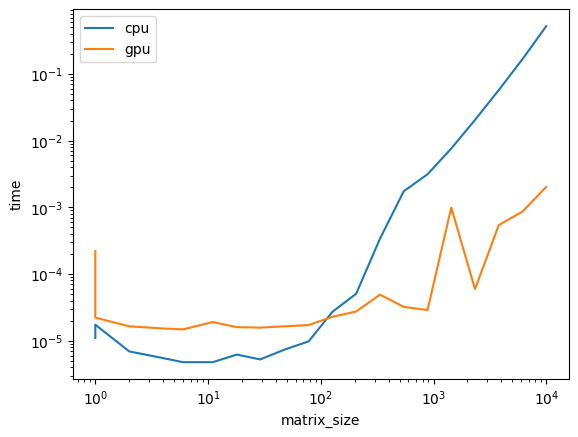

In [5]:
# plot time of cpu and gpu in multiplection
plt.plot(matrix_size_list,cpu_time,label='cpu')
plt.plot(matrix_size_list,gpu_time,label='gpu')
plt.xlabel('matrix_size')
plt.ylabel('time')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# image

In [6]:
import torch
import torch.nn as nn
import numpy as np
from scipy.signal import gaussian
from torch.autograd import Variable

In [7]:
# Load an image for processing
image_path = "/content/lena_color.tiff"
image = cv2.imread(image_path)
image.shape

(512, 512, 3)

In [8]:
# create a guassian2d filter for calculate image bluerd
filter_size = 5
gkern1d = gaussian(filter_size, std=1.0).reshape(filter_size, 1)
gkern2d = np.outer(gkern1d, gkern1d)

In [9]:
# A network of pytorch for calculate convolotional 2d
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.gaussian_filter_vertical = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=gkern2d.shape,bias=False)
        self.gaussian_filter_vertical.weight.data.copy_(torch.from_numpy(gkern2d))

    def forward(self, img):

        blur_vertical = self.gaussian_filter_vertical(img)

        return blur_vertical

net = Net()
net.eval()
# function to preprocess iinput image
def gpu_gaussian_filter(device,raw_img):
    net.to(device)
    img = torch.from_numpy(raw_img.transpose((2, 0, 1)))
    batch = torch.stack([img]).float().to(device)
    # just calculate convolotional time
    start = time()
    blurred_img = net(batch).to(device)
    return time()-start

In [10]:
# create scale of image
image_scale_list = np.linspace(0.1, 10 , 20, endpoint=True)
cpu_time = []
gpu_time = []
image_shape = []
for image_scale in image_scale_list:
    # resize image
    img = cv2.resize(image,None,fx=image_scale,fy=image_scale)
    image_shape.append(img.size)
    # the function return time of conv2d operation
    cpu_time.append(gpu_gaussian_filter('cpu',img))
    gpu_time.append(gpu_gaussian_filter("cuda",img))

    del img

In [ ]:
plt.plot(image_shape,cpu_time,label='cpu')
plt.plot(image_shape,gpu_time,label='gpu')
plt.xlabel('image_shape')
plt.ylabel('time')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# scenario

In [ ]:
# !pip install cupy


## scenario1

In [21]:
# ************************ Written by Alireza ************************************
import numpy as np
import time
import cupy as cp
# Define the matrix sizes
matrix_size = 1000
matrix_a = np.random.rand(matrix_size, matrix_size)
matrix_b = np.random.rand(matrix_size, matrix_size)

# CPU Matrix Multiplication
def cpu_matrix_multiplication(matrix_a, matrix_b):
    start_time = time.time()

    # Perform matrix multiplication using CPU
    cpu_result = np.dot(matrix_a, matrix_b)

    end_time = time.time()
    execution_time = end_time - start_time
    return cpu_result, execution_time

# GPU Matrix Multiplication
def gpu_matrix_multiplication(matrix_a, matrix_b):
    start_time = time.time()

    # Perform matrix multiplication using GPU
    gpu_matrix_a = cp.asarray(matrix_a)
    gpu_matrix_b = cp.asarray(matrix_b)
    gpu_result = cp.dot(gpu_matrix_a, gpu_matrix_b)
    cpu_result = cp.asnumpy(gpu_result)

    end_time = time.time()
    execution_time = end_time - start_time
    return cpu_result, execution_time

# Run CPU Matrix Multiplication
cpu_result, cpu_execution_time = cpu_matrix_multiplication(matrix_a, matrix_b)

# Run GPU Matrix Multiplication
gpu_result, gpu_execution_time = gpu_matrix_multiplication(matrix_a, matrix_b)

# Compare the results (optional)
print("CPU Result:")
print(cpu_result)
print("GPU Result:")
print(gpu_result)

# Print the execution times
print("CPU Execution Time:", cpu_execution_time, "seconds")
print("GPU Execution Time:", gpu_execution_time, "seconds")



CPU Result:
[[242.43117234 245.77612615 238.52277341 ... 249.7001409  234.96880102
  245.89424573]
 [251.74966782 247.54268072 244.74906954 ... 250.17983912 237.63524286
  248.75051589]
 [249.64033106 248.9401475  243.81106095 ... 256.63853528 239.86485462
  244.85569818]
 ...
 [252.11896451 254.2459511  250.46430388 ... 252.7293594  243.51722407
  254.97196935]
 [247.22163884 244.36439054 243.48760518 ... 247.48176663 231.09293628
  242.26922701]
 [243.36329487 248.14896774 248.88339485 ... 249.46499712 236.32055847
  245.81618153]]
GPU Result:
[[242.43117234 245.77612615 238.52277341 ... 249.7001409  234.96880102
  245.89424573]
 [251.74966782 247.54268072 244.74906954 ... 250.17983912 237.63524286
  248.75051589]
 [249.64033106 248.9401475  243.81106095 ... 256.63853528 239.86485462
  244.85569818]
 ...
 [252.11896451 254.2459511  250.46430388 ... 252.7293594  243.51722407
  254.97196935]
 [247.22163884 244.36439054 243.48760518 ... 247.48176663 231.09293628
  242.26922701]
 [243.36

## scenario2

In [ ]:
# install opencv with support cuda
!git clone https://github.com/opencv/opencv
!git clone https://github.com/opencv/opencv_contrib
!mkdir /content/build
%cd /content/build
!cmake -DOPENCV_EXTRA_MODULES_PATH=/content/opencv_contrib/modules  -DBUILD_SHARED_LIBS=OFF  -DBUILD_TESTS=OFF  -DBUILD_PERF_TESTS=OFF -DBUILD_EXAMPLES=OFF -DWITH_OPENEXR=OFF -DWITH_CUDA=ON -DWITH_CUBLAS=ON -DWITH_CUDNN=ON -DOPENCV_DNN_CUDA=ON /content/opencv
!make -j8 install


Cloning into 'opencv'...
remote: Enumerating objects: 318647, done.
remote: Counting objects: 100% (344/344), done.
remote: Compressing objects: 100% (177/177), done.
remote: Total 318647 (delta 166), reused 301 (delta 160), pack-reused 318303
Receiving objects: 100% (318647/318647), 507.44 MiB | 14.11 MiB/s, done.
Resolving deltas: 100% (221719/221719), done.
Updating files: 100% (7183/7183), done.
Cloning into 'opencv_contrib'...
remote: Enumerating objects: 39452, done.
remote: Counting objects: 100% (340/340), done.
remote: Compressing objects: 100% (187/187), done.
remote: Total 39452 (delta 166), reused 279 (delta 139), pack-reused 39112
Receiving objects: 100% (39452/39452), 133.97 MiB | 18.17 MiB/s, done.
Resolving deltas: 100% (24602/24602), done.
/content/build
-- 'Release' build type is used by default. Use CMAKE_BUILD_TYPE to specify build type (Release or Debug)
-- The CXX compiler identification is GNU 9.4.0
-- The C compiler identification is GNU 9.4.0
-- Detecting CXX c

In [ ]:
# ****************************************** written by Alireza ***************************************
import cv2
import time

# Load an image for processing
image_path = "/content/lena_color.tiff"
image = cv2.imread(image_path)

# CPU Image Processing
def cpu_image_processing(image):
    start_time = time.time()

    # Perform image processing operations using CPU
    # Example: Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    end_time = time.time()
    execution_time = end_time - start_time
    return gray_image, execution_time

# GPU Image Processing
def gpu_image_processing(image):
    start_time = time.time()

    # Perform image processing operations using GPU
    # Example: Convert the image to grayscale
    gpu_image = cv2.cuda_GpuMat()
    gpu_image.upload(image)
    gpu_gray_image = cv2.cuda.cvtColor(gpu_image, cv2.COLOR_BGR2GRAY)
    gray_image = gpu_gray_image.download()

    end_time = time.time()
    execution_time = end_time - start_time
    return gray_image, execution_time

# Run CPU Image Processing
cpu_result, cpu_execution_time = cpu_image_processing(image)

# Run GPU Image Processing
gpu_result, gpu_execution_time = gpu_image_processing(image)

# Display the results and execution times
cv2.imshow("CPU Result", cpu_result)
cv2.imshow("GPU Result", gpu_result)
cv2.waitKey(0)

print("CPU Execution Time:", cpu_execution_time, "seconds")
print("GPU Execution Time:", gpu_execution_time, "seconds")
